In [1]:
import pickle
import numpy as np
import mysql.connector
import astropy.units as u
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee
import corner

from sdf import photometry
from sdf import model
from sdf import spectrum
from sdf import fitting
from sdf import filter
from sdf import analytics
from sdf import utils

%matplotlib notebook

In [2]:
mpl.rc('lines', linewidth=3)
mpl.rc('axes', linewidth=1)

# SED plot, showing possible disk properties

In [3]:
with open('seds/hd116434/sdb-v1-132436.10-513016.1-mnest/phoenix_m+modbb_disk_r_.pkl','rb') as f:
    r = pickle.load(f)
        
# refill these
mod,plmod = model.get_models(r.obs,r.model_comps)
r.models = mod
r.pl_models = plmod

lstar = r.star[0]['lstar']
tstar = r.comp_best_params[0][0]
parallax = r.star[0]['plx_arcsec']

In [4]:
params,sampler = fitting.run_emcee(r,nwalkers=500,nstep=1000)
temps = 10**params[:,4]
radii = np.sqrt(17.) * ( 278.3/temps )**2

/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


<IPython.core.display.Javascript object>


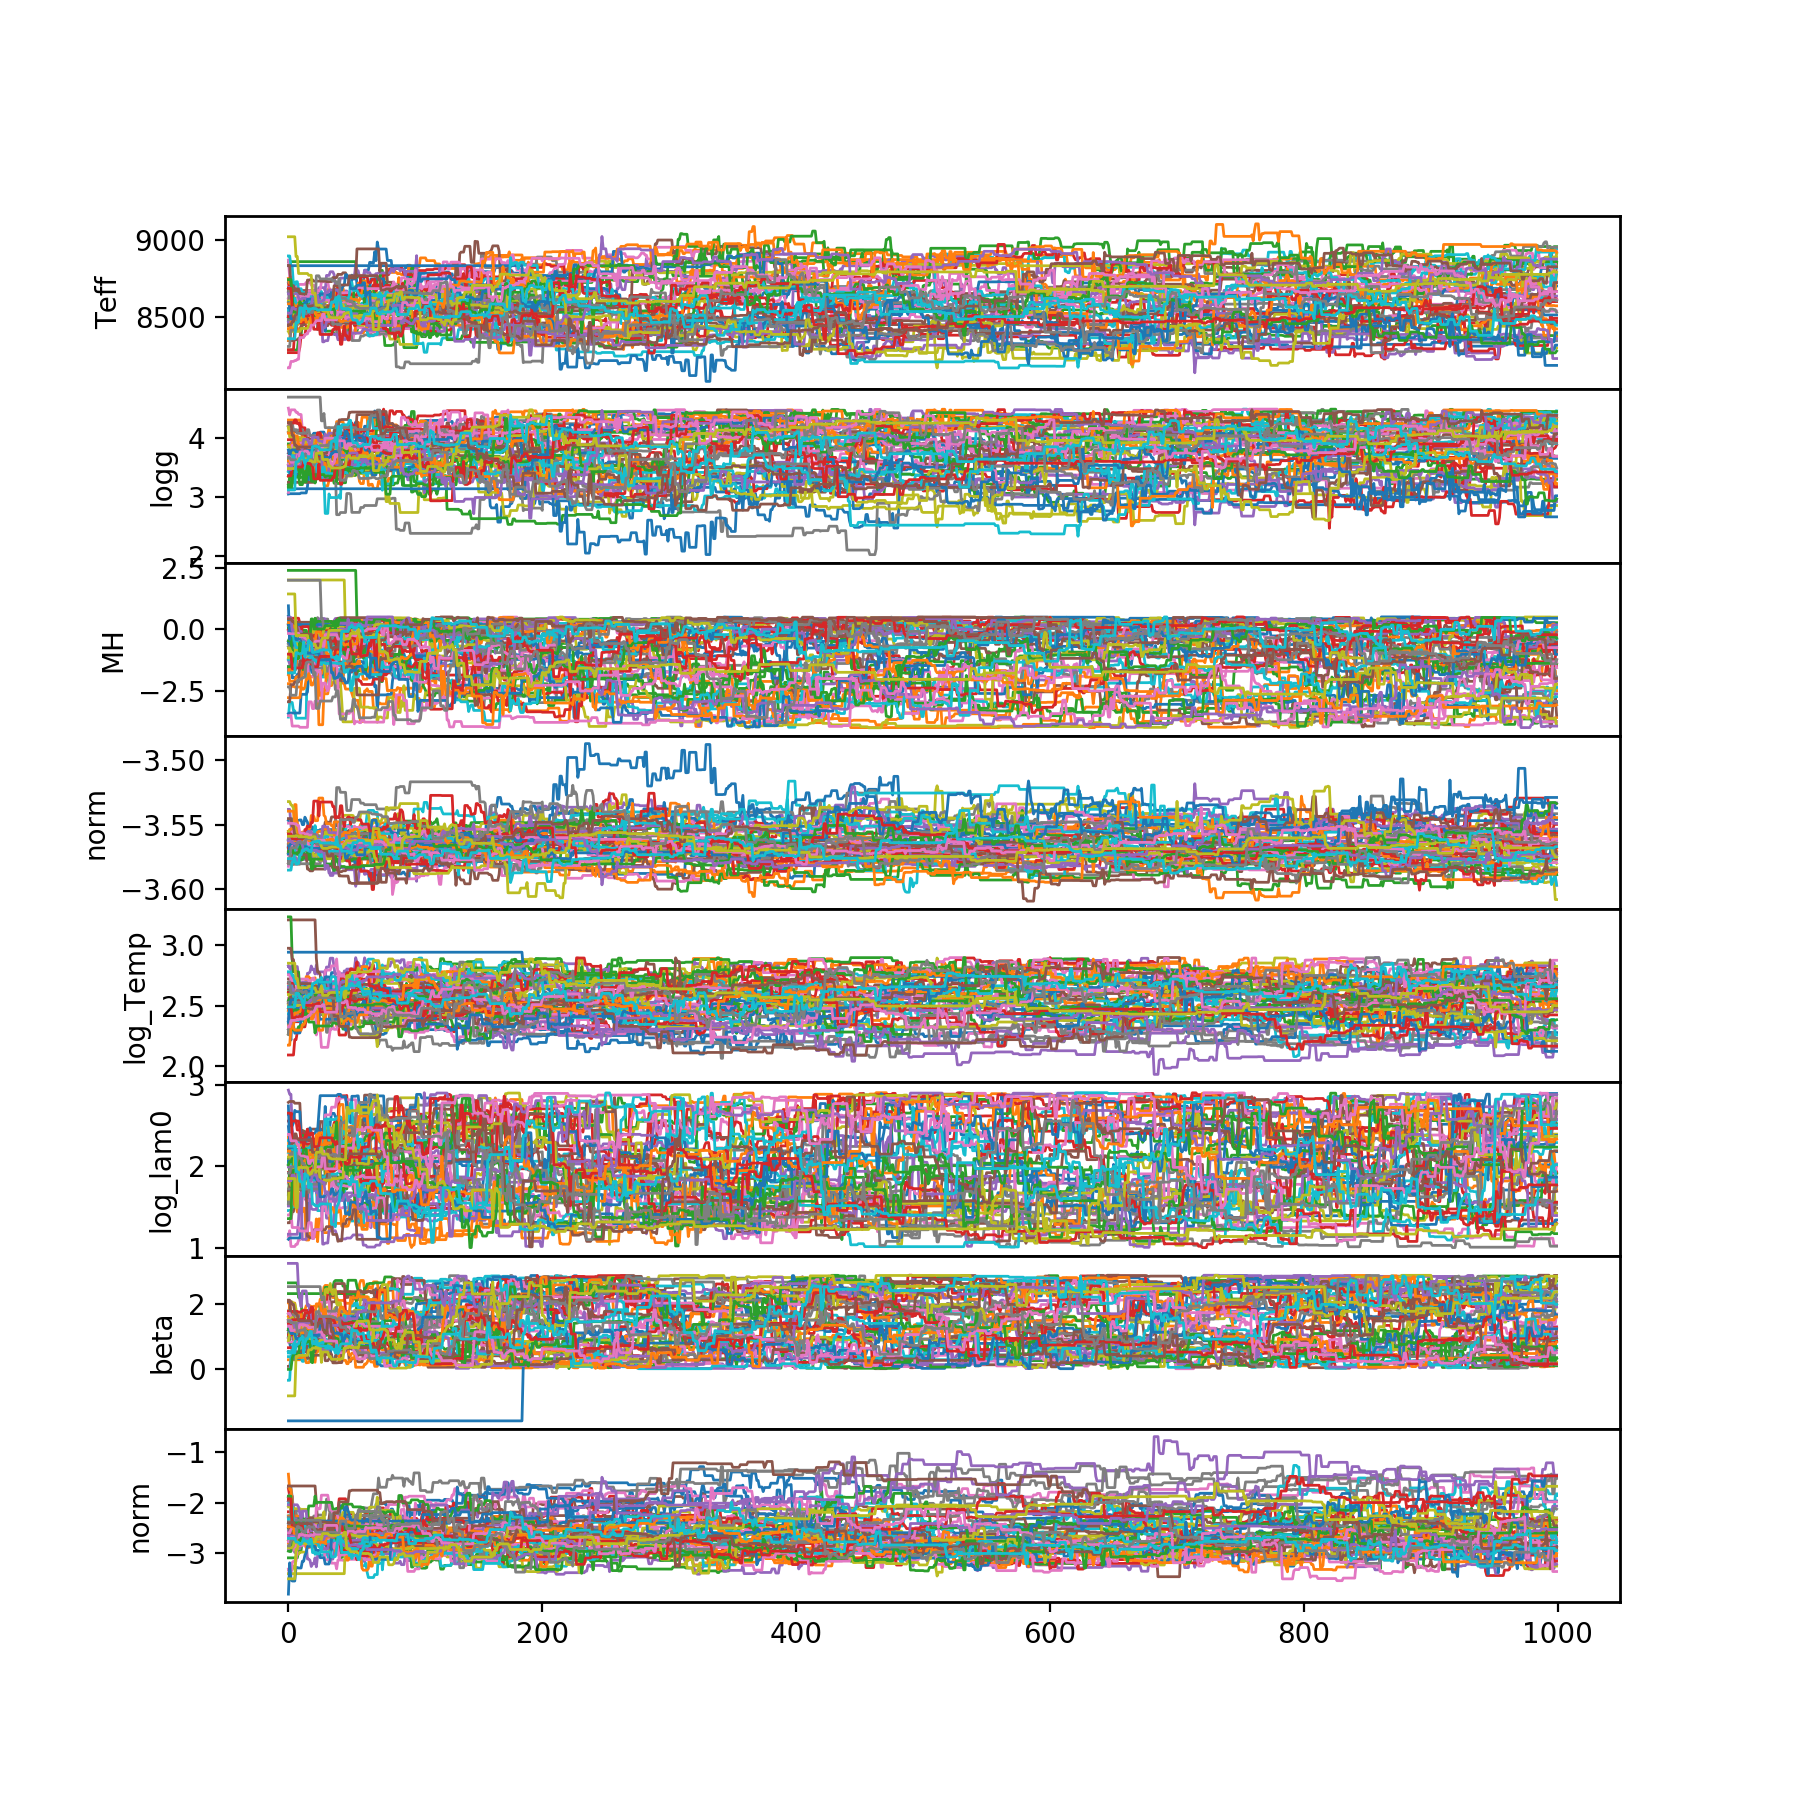

In [5]:
fig,ax = plt.subplots(r.model_info['ndim'],sharex=True,figsize=(9,9))

for i in range(r.model_info['ndim']):
    for j in range(50):
        ax[i].plot(sampler.chain[j,:,i],linewidth=1)
        ax[i].set_ylabel(r.parameters[i])

fig.subplots_adjust(hspace=0)

<IPython.core.display.Javascript object>


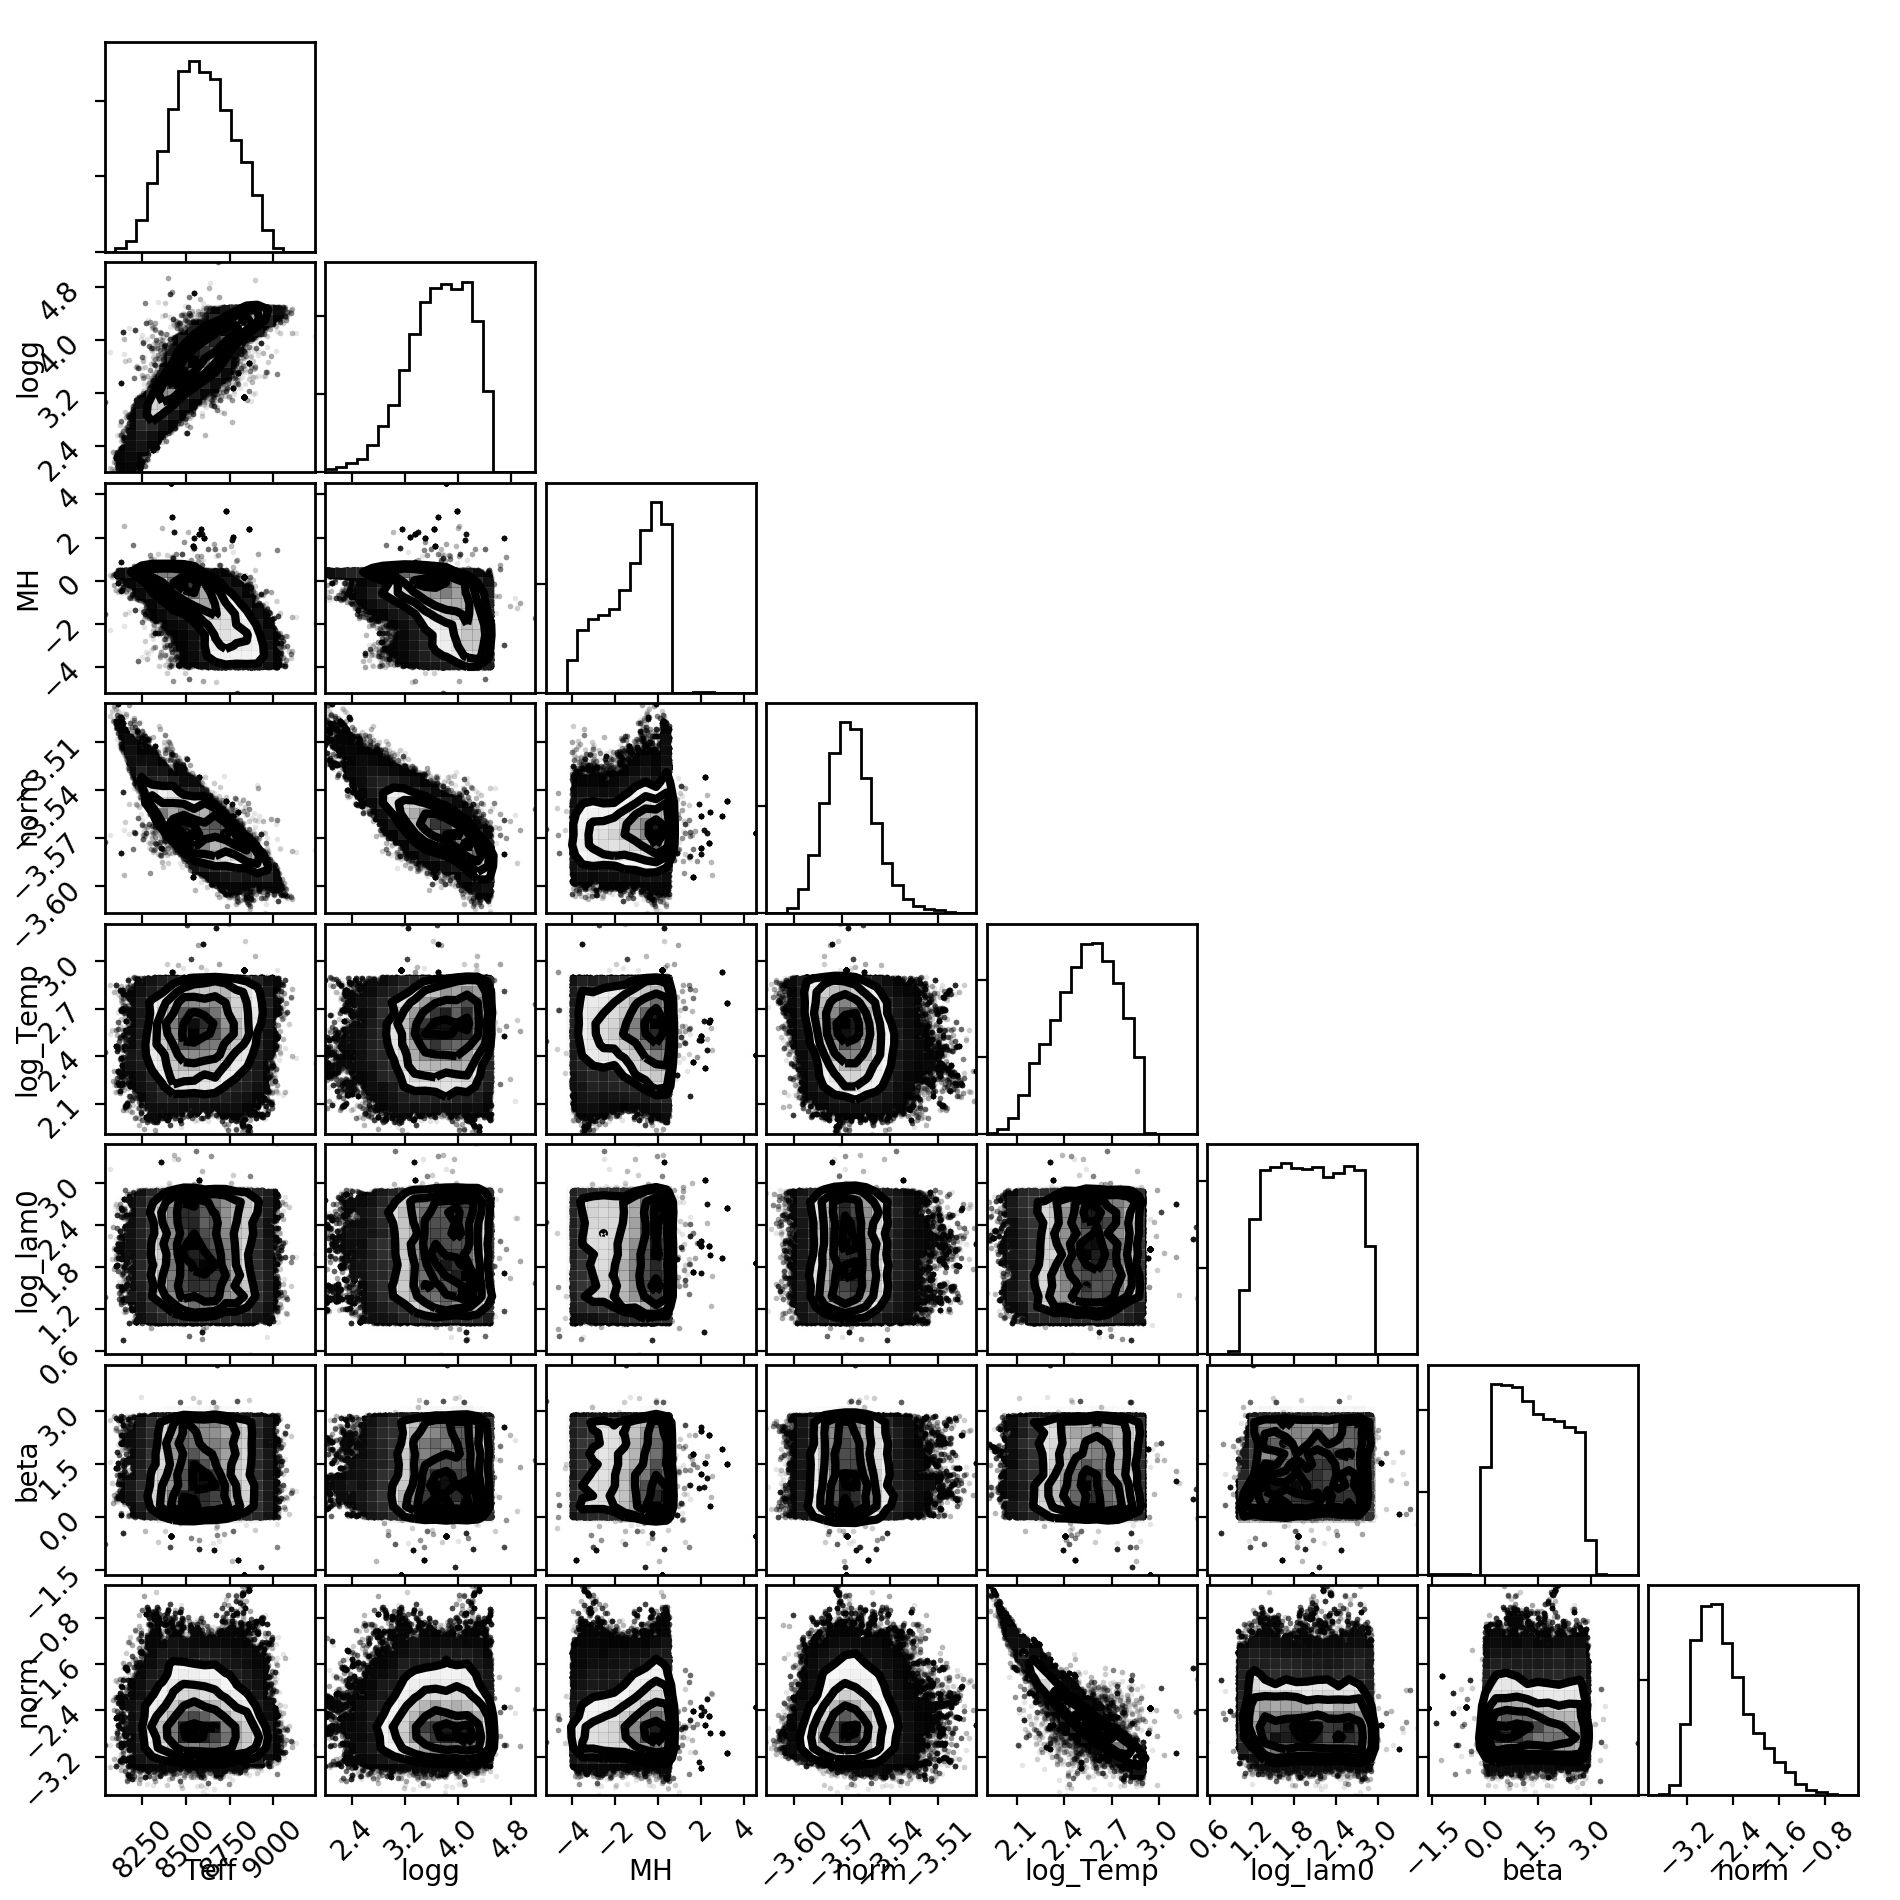

In [6]:
fig,ax = plt.subplots(r.model_info['ndim'],r.model_info['ndim'],figsize=(9.5,9.5))

_ = corner.corner(sampler.chain[:,:,:].reshape((-1, r.model_info['ndim'])),
                  fig=fig,labels=r.parameters)

<IPython.core.display.Javascript object>


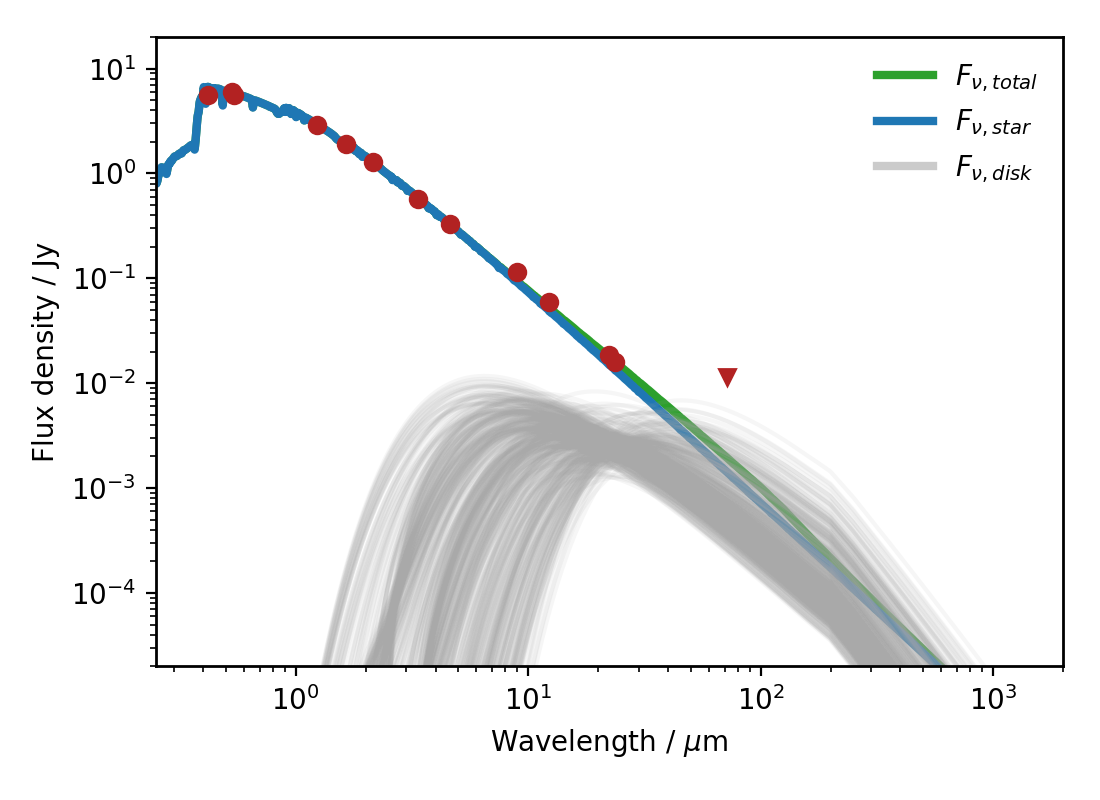

In [55]:
fig,ax = plt.subplots(figsize=(5.5,4))

# stellar and total spectra
ax.plot(r.total_spec.wavelength,r.total_spec.fnujy,color='C2',label='$F_{\\nu,total}$')
ax.loglog(r.comp_spectra[0].wavelength,r.comp_spectra[0].fnujy,label='$F_{\\nu,star}$')

# photometry
for p in r.obs:
    if not isinstance(p,photometry.Photometry):
        continue

    ok = np.invert(np.logical_or(p.upperlim,p.ignore))
    for i,f in enumerate(p.filters):
        if filter.iscolour(f):
            ok[i] = False

    ax.errorbar(p.mean_wavelength()[ok],p.fnujy[ok],yerr=p.e_fnujy[ok],
                fmt='o',color='firebrick')
    ax.plot(p.mean_wavelength()[p.upperlim],p.fnujy[p.upperlim],'v',color='firebrick')

# plot emcee samples
f880 = []
f1300 = []
ldisk_1pc = []
for par in sampler.chain[:,-1,:]:
    for m in r.pl_models[1]:
        if not isinstance(m,model.SpecModel):
            continue
        s = spectrum.ObsSpectrum(wavelength=m.wavelength,
                                 fnujy=m.fnujy([par[4],2.322,1,par[7]]))
        ax.plot(s.wavelength,s.fnujy,color='darkgrey',alpha=0.1,linewidth=1.5)
        
        s.fill_irradiance()
        ldisk_1pc.append(s.irradiance *4*np.pi*(u.pc.to(u.m))**2 / u.L_sun.to(u.W))
        f880.append(s.fnujy[486])
        f1300.append(s.fnujy[410])

ax.plot(-1,-1,color='darkgrey',alpha=0.6,label='$F_{\\nu,disk}$')

# IRAS, 3x template amplitude from SCANPI
# plt.plot([60,100],[0.6,1.5],'v')

# sofia
# ax.plot([53,63,89,154,214],[.175,.199,.148,.115,.101],'--')

# alma
# ax.plot([880],[20e-6],'o',color='black')
# ax.plot([880],[200e-6],'o',color='black')
# ax.plot([880,880],[20e-6,200e-6],color='black')

# free-free extrapolation
# x = 10**np.linspace(-1,5,100)
# ax.plot(x,0.0023/0.15*x**(-0.6),'--')

ax.set_xlabel('Wavelength / $\mu$m')
ax.set_ylabel('Flux density / Jy')

ax.set_xlim(0.25,2e3)
ax.set_ylim(2e-5,20)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('sed.pdf')

<IPython.core.display.Javascript object>


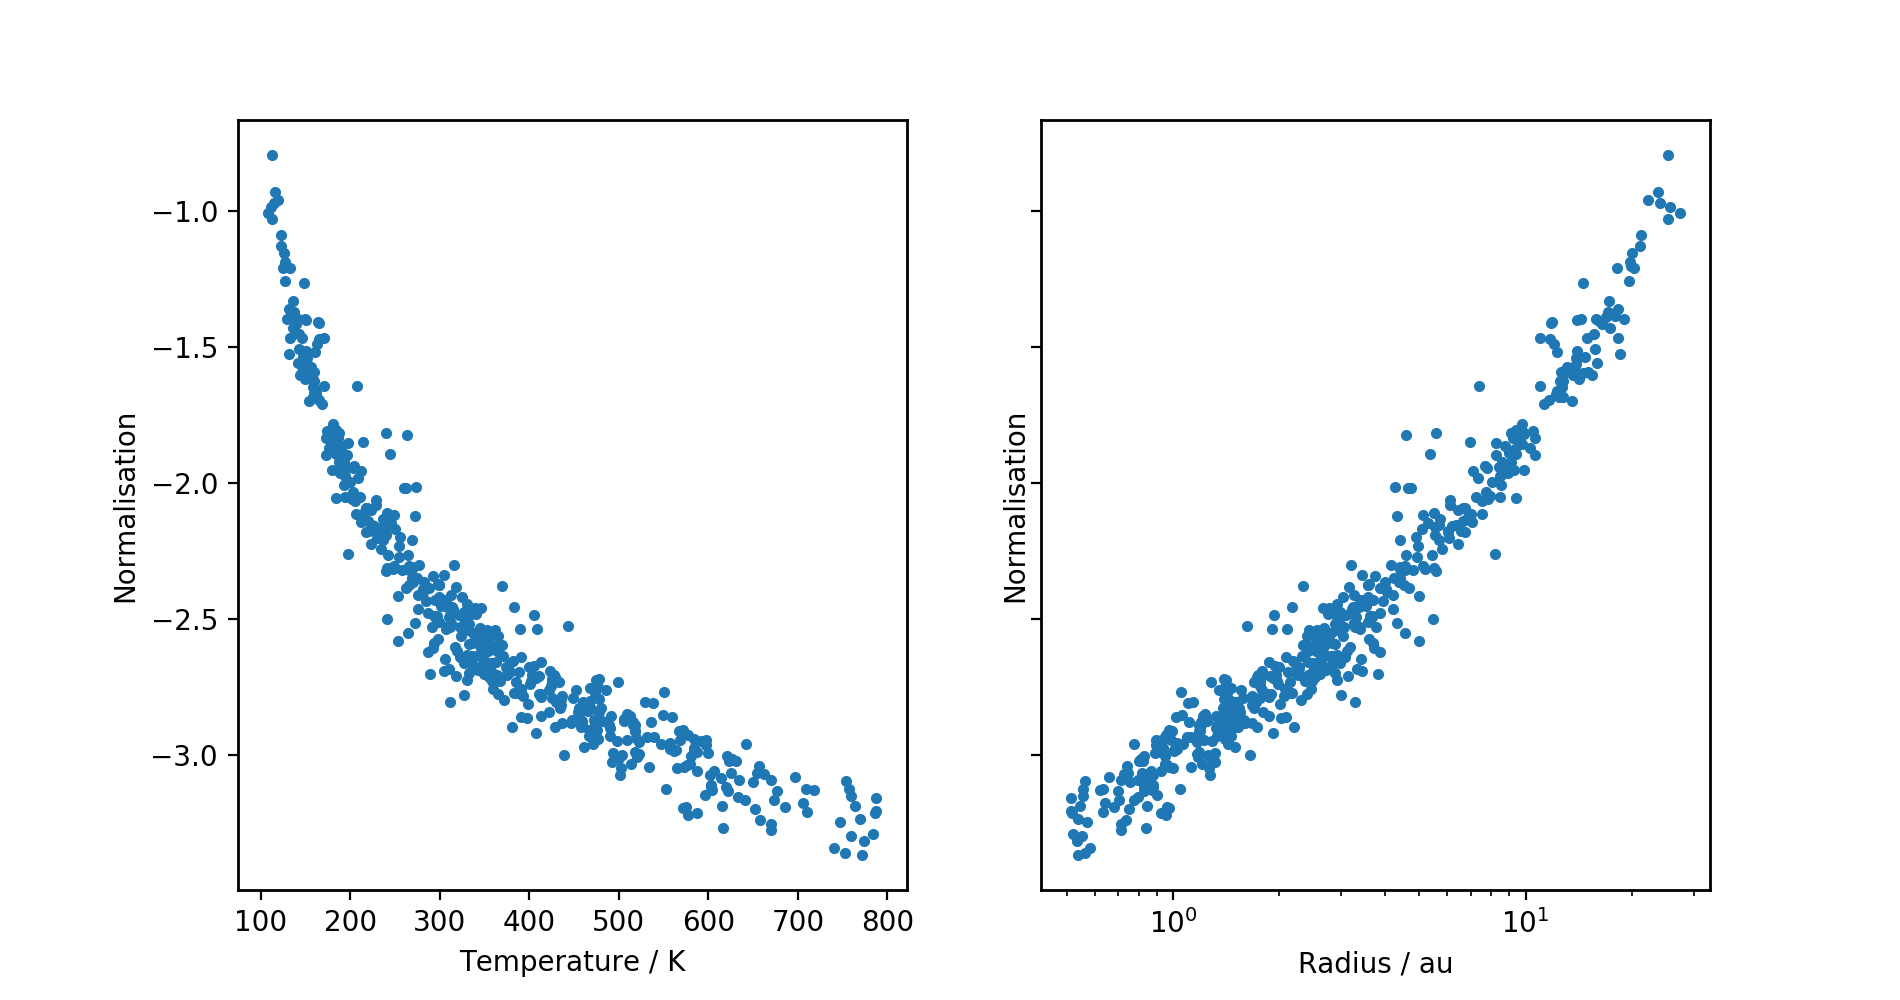

In [8]:
fig,ax = plt.subplots(1,2,figsize=(9.5,5),sharey=True)

ax[0].plot(temps,params[:,7],'.')
ax[0].set_xlabel('Temperature / K')
ax[0].set_ylabel('Normalisation')

ax[1].semilogx(radii,params[:,7],'.')
ax[1].set_xlabel('Radius / au')
ax[1].set_ylabel('Normalisation')

<IPython.core.display.Javascript object>


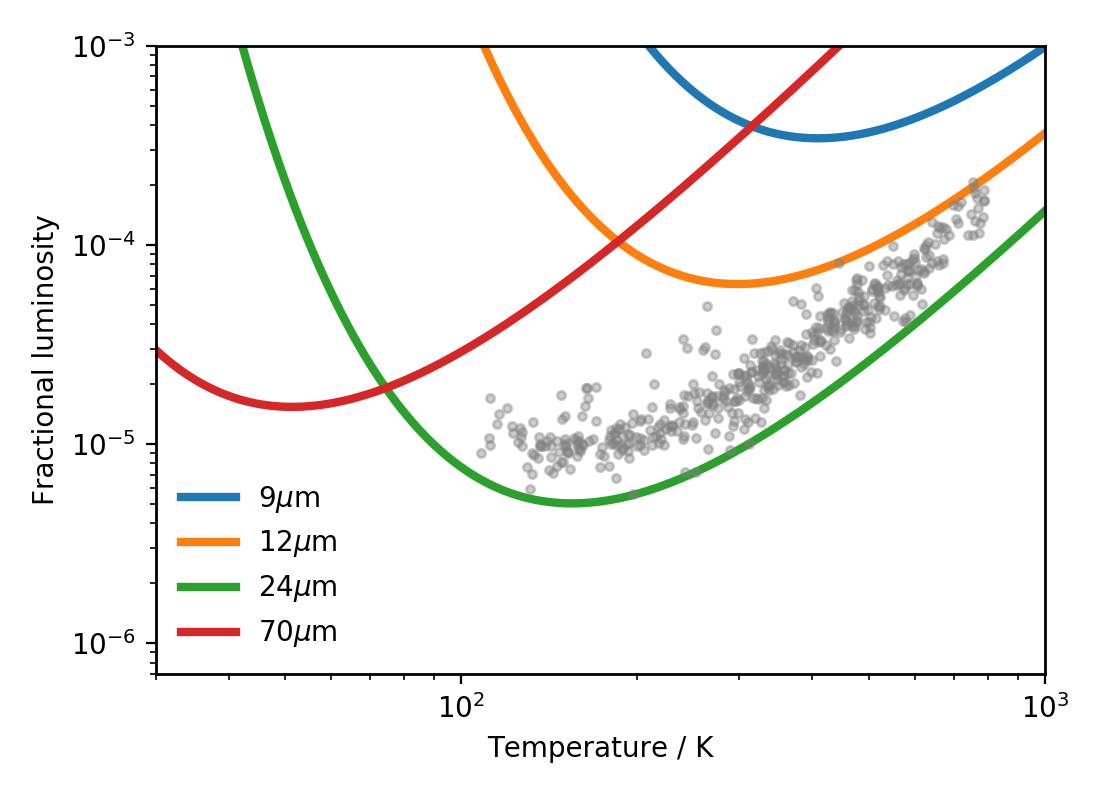

In [9]:
bb = analytics.BB_Disk(lstar=r.star[0]['lstar'],tstar=tstar,distance=1.0/parallax)
labels = ['$9\mu$m','$12\mu$m','$24\mu$m','$70\mu$m']
# lim = bb.f_limits(np.array([12,24,70]),
#                   stellar_flux=np.array(r.all_star_phot)[[70,80,81]],
#                   flux_limits=np.array([3*2.586e-3,999,1.14e-2]),
#                   r_limits=np.array([0.15,3*0.042,999]))
lim,_ = bb.f_limits_from_result(r,keep_filters=['AKARI9','WISE12','MIPS24','MIPS70'])

fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.temperatures,lim[:,i],label=labels[i])
    
ldisk_lstar = np.array(ldisk_1pc) / parallax**2 / lstar
ax.plot(10**params[:,4],ldisk_lstar,'.',color='grey',alpha=0.4)

ax.set_xlabel('Temperature / K')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(30,1000)
ax.set_ylim(0.7e-6,1e-3)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_T.pdf')

<IPython.core.display.Javascript object>


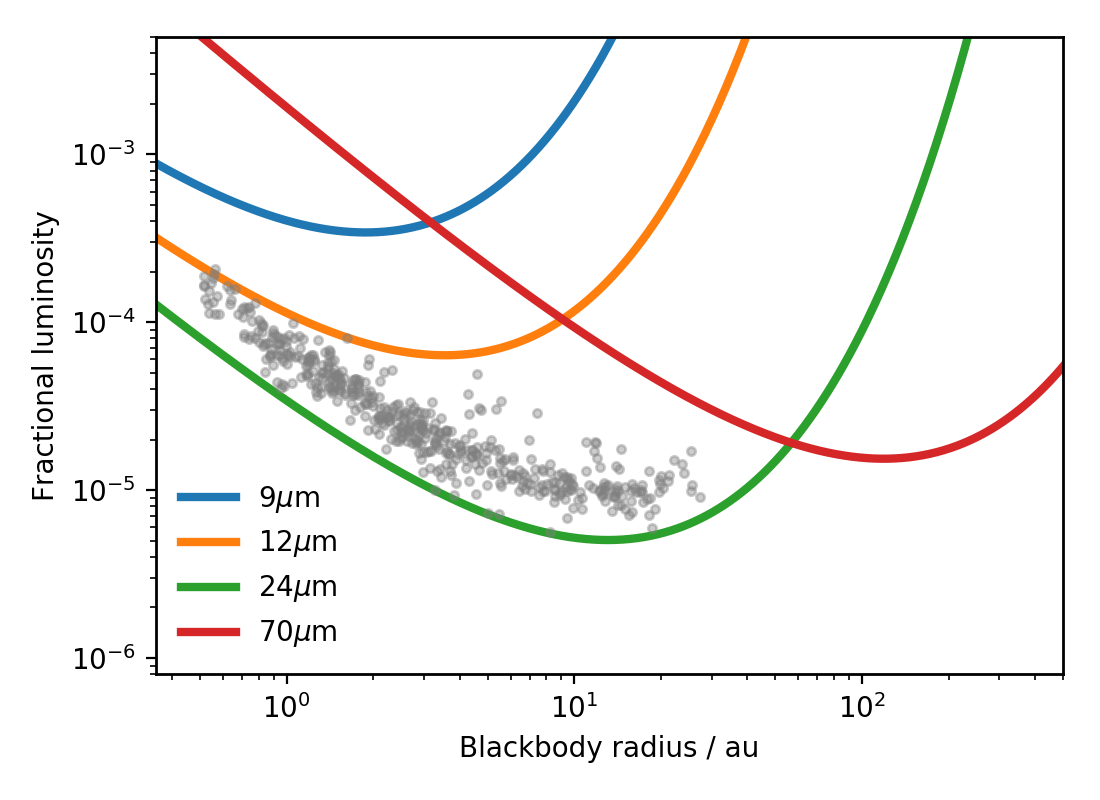

In [10]:
fig,ax = plt.subplots(figsize=(5.5,4))

for i in range(lim.shape[1]):
    ax.loglog(bb.blackbody_radii(),lim[:,i],label=labels[i])
    
ax.plot(radii,ldisk_lstar,'.',color='grey',alpha=0.4)

ax.set_xlabel('Blackbody radius / au')
ax.set_ylabel('Fractional luminosity')

ax.set_xlim(0.35,500)
ax.set_ylim(0.8e-6,5e-3)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('f_r.pdf')

# A/F stars with imaged planets

<IPython.core.display.Javascript object>


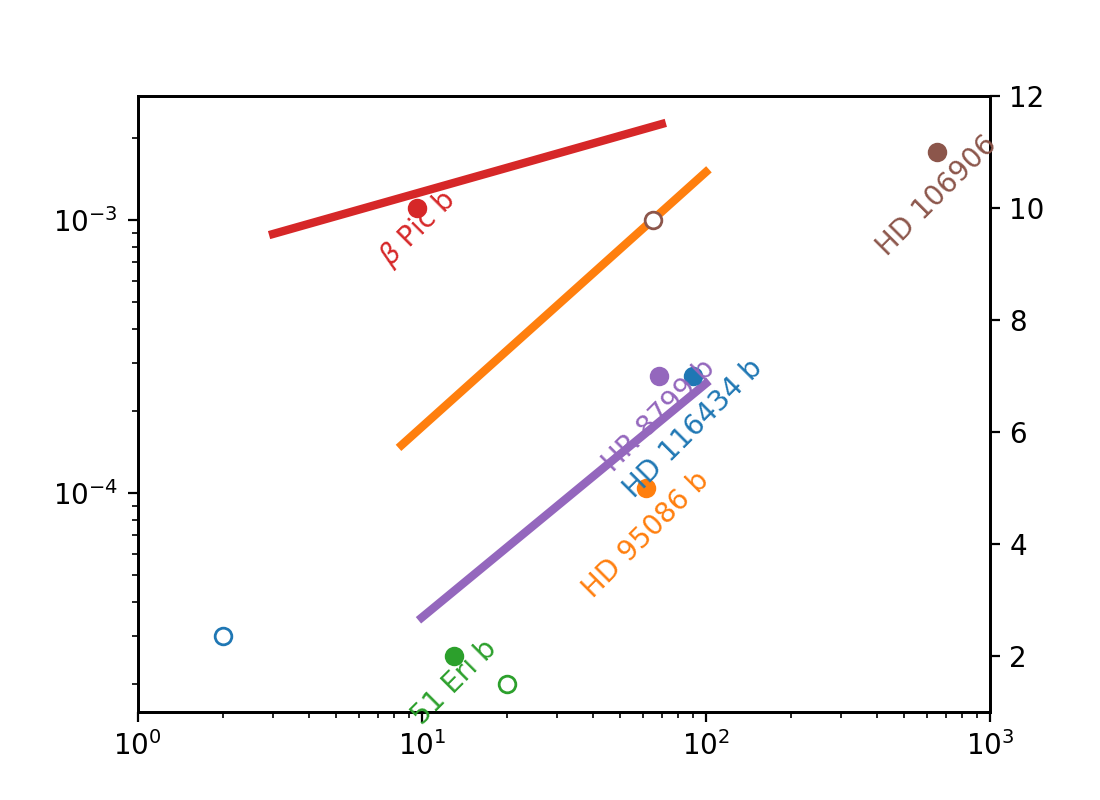

(1, 1000)

In [11]:
fig,ax1 = plt.subplots(figsize=(5.5,4))

col = ['C0','C1','C2','C3','C4','C5']

ref =      ['Chauvin+17', 'Rameau+16', 'Blunt+17','Wang+16',      'Wertz+17', 'Bailey+14']
names =    ['HD 116434 b','HD 95086 b','51 Eri b',r'$\beta$ Pic b','HR 8799 b','HD 106906']
m_planet = [ 7,            5 ,          2,         10,             7,          11]
a_planet = [ 90,           61.7,        13,        9.66,           68.22,      650]
r_disk =   [2,            (8.5,100),    20,       (3,70),        (10,100),     65]
f_disk =   [3e-5,     (1.5e-4,1.5e-3),  2e-5, (8.9e-4,2.25e-3),(3.5e-5,2.52e-4),1e-3]

for i,n in enumerate(names):
    if isinstance(r_disk[i],tuple):
        ax1.loglog(r_disk[i],f_disk[i],color=col[i])
    else:
        ax1.loglog(r_disk[i],f_disk[i],'o',markeredgecolor=col[i],markerfacecolor='white')

ax2 = ax1.twinx()

for i,n in enumerate(names):
    ax2.plot(a_planet[i],m_planet[i],'o',color=col[i])
    ax2.text(a_planet[i],m_planet[i],n,rotation=45,horizontalalignment='center',color=col[i])
    
ax2.set_ylim(1,12)
ax2.set_xlim(1,1000)

# Population properties, is the excess really plausible?

In [12]:
cnx = mysql.connector.connect(user='reader',password='7V%2525Br4@p',host='localhost',database='sdb_results_tmp')
cursor = cnx.cursor(buffered=True)

In [13]:
cursor.execute("SELECT name,R_star,"
               "substring_index(substring(parameters,2),',',1)*1 as teff,f_F24 "
               "FROM model LEFT JOIN phot using (id) LEFT JOIN sdb_samples.chen_2012_ on id=sdbid "
               "LEFT JOIN photometry.chen12 using (name) "
               "WHERE sdbid IS NOT NULL and filter='MIPS24' and obs_upperlim=0;")

In [14]:
a=np.array(cursor.fetchall())

<IPython.core.display.Javascript object>


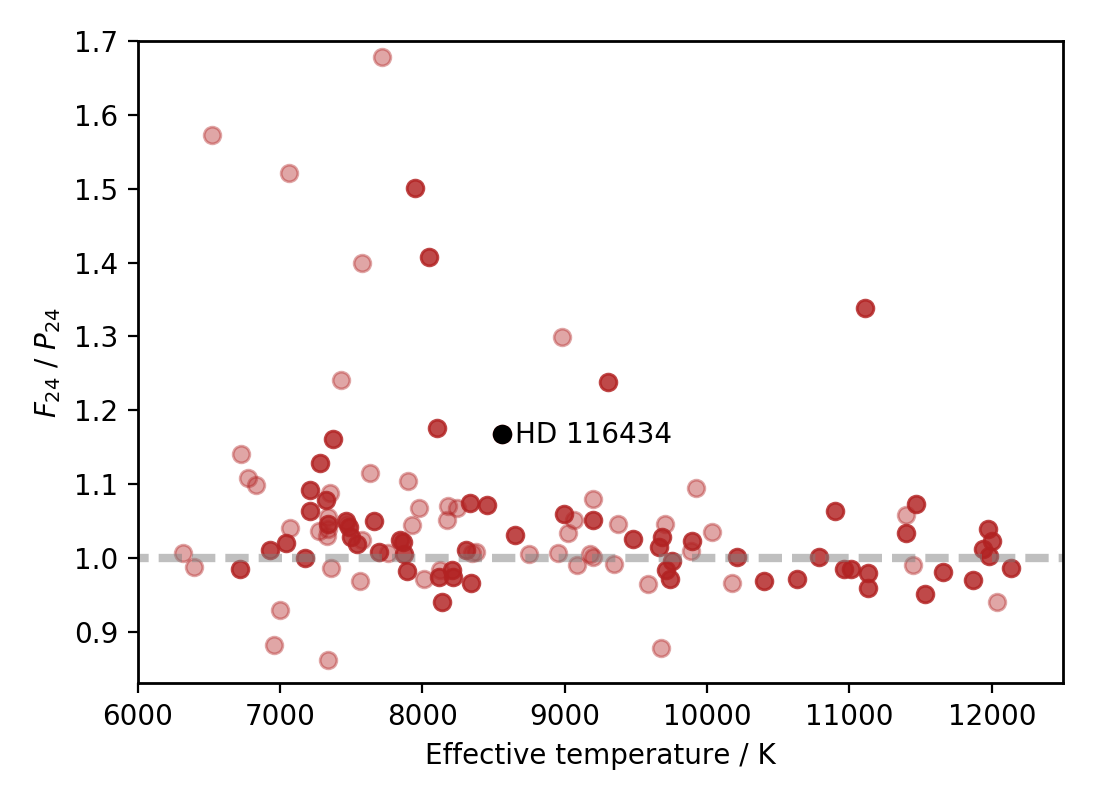

In [15]:
fig,ax = plt.subplots(figsize=(5.5,4))

# bulk
ax.plot(a[:,2],a[:,1],'o',color='firebrick',alpha=0.4)

j = np.where(a[:,3]=='N')
ax.plot(a[j,2],a[j,1],'o',color='firebrick',alpha=0.7)

i = np.where(a[:,0]=='HD 116434')[0][0]
ax.plot(a[i,2],a[i,1],'o',color='black')
ax.text(8650,1.155,'HD 116434')

ax.plot(ax.get_xlim(),[1,1],'--',color='grey',alpha=0.5)

ax.set_xlim(6000,1.25e4)
ax.set_ylim(0.83,1.7)
ax.set_xlabel('Effective temperature / K')
ax.set_ylabel('$F_{24}$ / $P_{24}$')

fig.tight_layout()
fig.savefig('r_Teff.pdf')

In [27]:
np.sum( (np.array(a[:,1],dtype=float) > (1.003+3*0.04)) &
        (np.array(a[:,2],dtype=float) < 9700) &
        (a[:,3] == 'N') )

26

In [30]:
np.sum( (np.array(a[:,1],dtype=float) < (1.01+3*0.045)) &
        (np.array(a[:,2],dtype=float) < 9700) )

76

In [18]:
cnx = mysql.connector.connect(user='reader',password='7V%2525Br4@p',host='localhost',database='sdb_results_tmp')
cursor = cnx.cursor(buffered=True)

In [19]:
cursor.execute("select R_star from phot "
               "where filter='MIPS24' and obs_jy is not null and R_star BETWEEN 0.8 and 1.25")
r_all = np.array(cursor.fetchall())

cursor.execute("select R_star from phot left join sdb_samples.chen_2012_ on id=sdbid "
               "left join photometry.chen12 using (name) "
               "where filter='MIPS24' and obs_jy is not null and f_F24='N' and R_star BETWEEN 0.8 and 1.25")
r_clean = np.array(cursor.fetchall())

In [20]:
# mirror just the points lower than 1
# r_all = r_all[np.where(r_all<1.0)[0]]
# r_all = np.append(r_all,1+(1-r_all))

# r_clean = r_clean[np.where(r_clean<1.0)[0]]
# r_clean = np.append(r_clean,1+(1-r_clean))

In [21]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

<IPython.core.display.Javascript object>


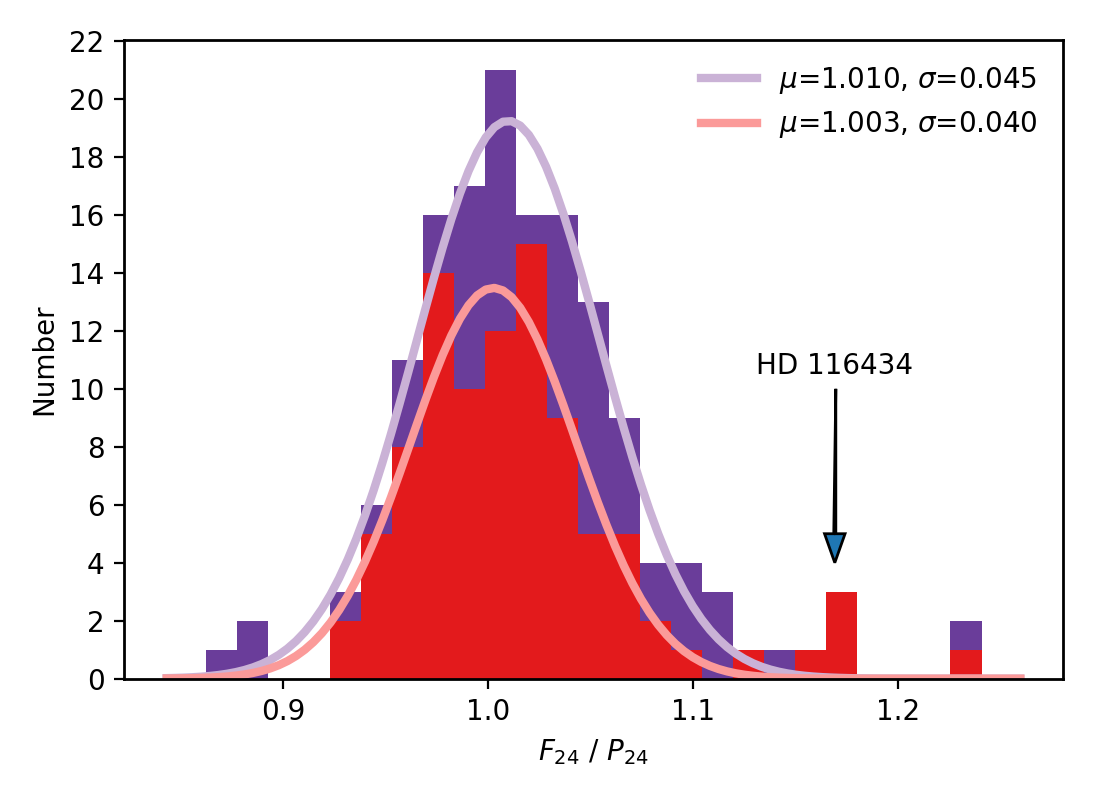

[ 13.48357057   1.00265404   0.04033511] 1.1639944866


In [36]:
fig,ax = plt.subplots(figsize=(5.5,4))
cm = plt.get_cmap('Paired').colors

hist_all,edges_all,_ = ax.hist(r_all,bins=25,color=cm[9])
hist_clean,_,_ = ax.hist(r_clean,bins=edges_all,color=cm[5])

cen = (edges_all[1:]+edges_all[:-1])/2.
x = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
coeff, var_matrix = curve_fit(gauss, cen, hist_all, p0=[17,1,0.05])
ax.plot(x, gauss(x, *coeff),color=cm[8],
        label='$\mu$={:1.3f}, $\sigma$={:1.3f}'.format(coeff[1],coeff[2]))
# print(coeff,coeff[1]+3.5*coeff[2])

coeff, var_matrix = curve_fit(gauss, cen, hist_clean, p0=[12,1,0.05])
ax.plot(x, gauss(x, *coeff),color=cm[4],
        label='$\mu$={:1.3f}, $\sigma$={:1.3f}'.format(coeff[1],coeff[2]))
print(coeff,coeff[1]+4*coeff[2])

ax.arrow(1.1691,10,0,-5,head_width=0.01, head_length=1,)
ax.text(1.1691,10.5,'HD 116434',horizontalalignment='center')

ax.set_yticks(np.arange(0, 23, 2.0))

ax.legend(frameon=False)
ax.set_xlabel('$F_{24}$ / $P_{24}$')
ax.set_ylabel('Number')

fig.tight_layout()
fig.savefig('r.pdf')

# Future detection
ouch

<IPython.core.display.Javascript object>


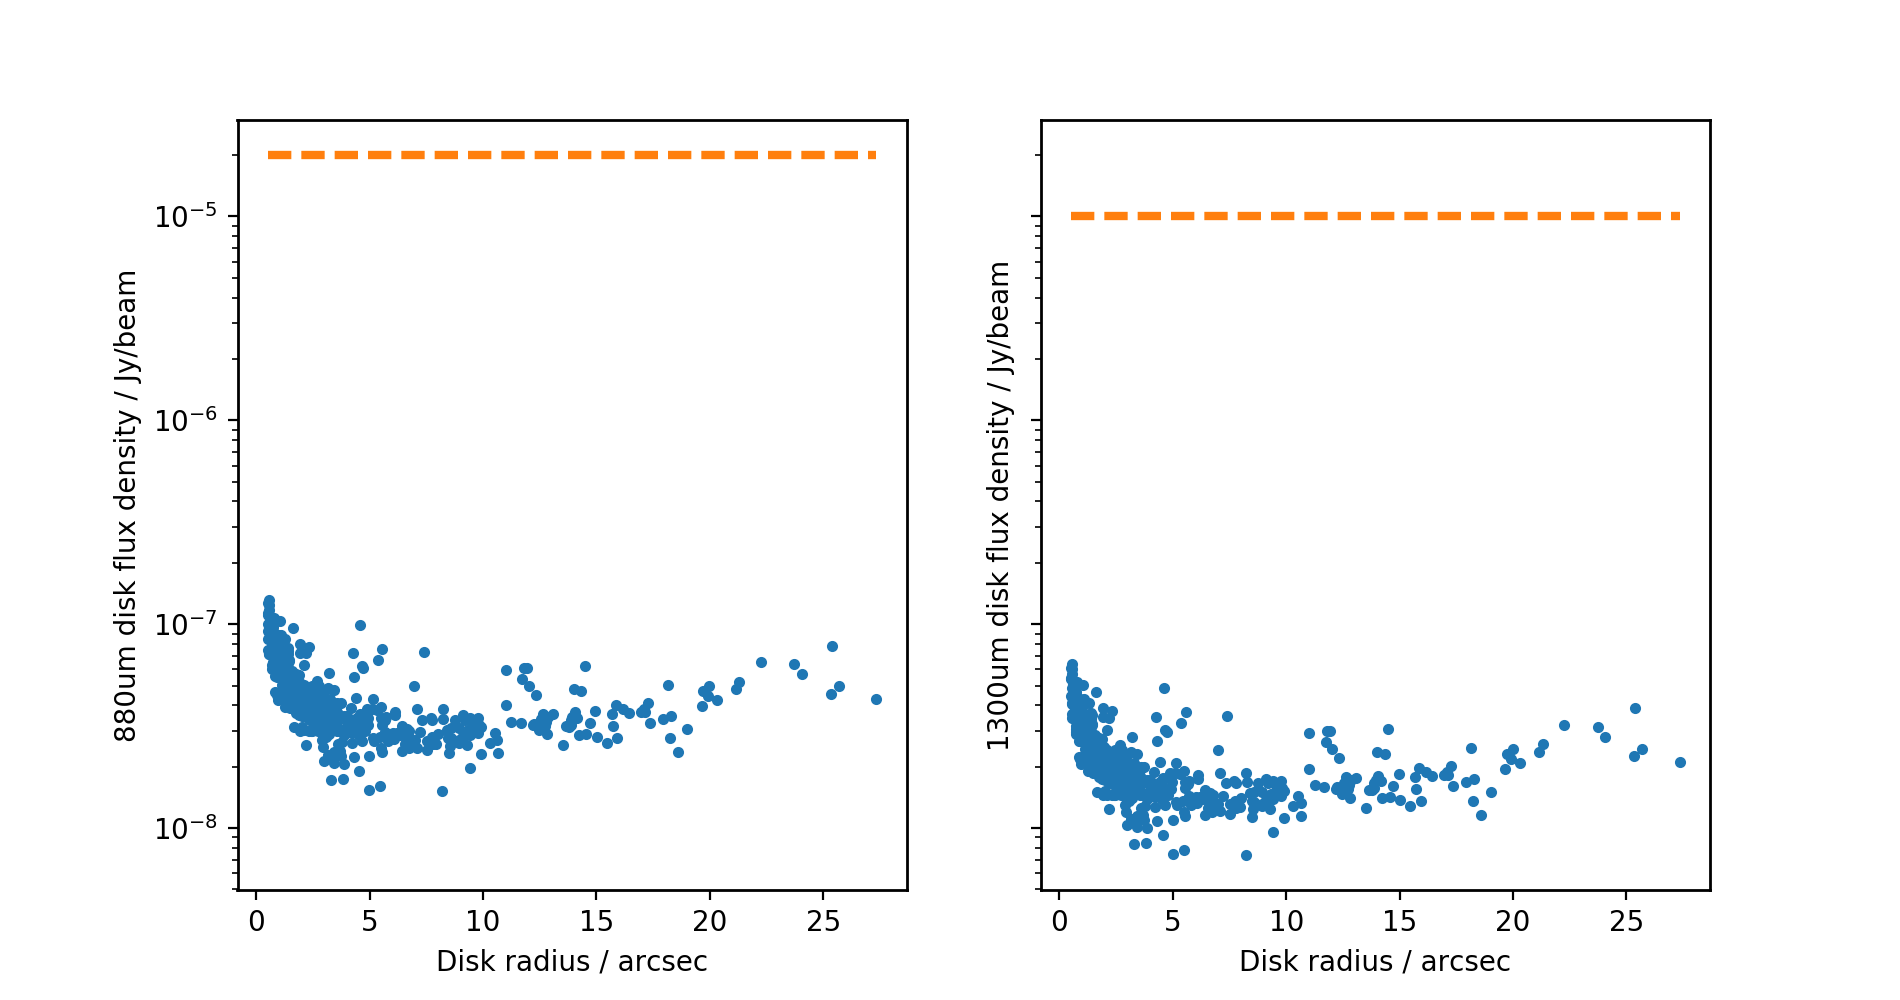

In [23]:
# disk flux per beam and sensitivity
fig,ax = plt.subplots(1,2,figsize=(9.5,5),sharey=True)

nbeam = ( (2*np.pi*radii*radii/2.) / 0.16**2 )
ax[0].semilogy( radii, f880/np.sqrt(nbeam),'.') # face-on disk
# ax[0].semilogy( r, f880/(r/0.16),'.') # edge-on disk
ax[0].plot([np.min(radii),np.max(radii)],[20e-6,20e-6],'--')
ax[0].set_xlabel('Disk radius / arcsec')
ax[0].set_ylabel('880um disk flux density / Jy/beam')

nbeam = ( (2*np.pi*radii*radii/2.) / 0.24**2 )
ax[1].semilogy( radii, f1300/np.sqrt(nbeam),'.')
ax[1].plot([np.min(radii),np.max(radii)],[10e-6,10e-6],'--')
ax[1].set_xlabel('Disk radius / arcsec')
ax[1].set_ylabel('1300um disk flux density / Jy/beam')